<a href="https://colab.research.google.com/github/devbravo/CNN_Image_Classification/blob/main/Cats%26Dogs_Image_class.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pathlib
import zipfile
import datetime
import os

import numpy as np
import PIL
import matplotlib.pyplot as plt
import seaborn as sns

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping

import tensorflow as tf

In [2]:
dataset_path = '/tmp/cats-and-dogs.zip'

if not os.path.exists(dataset_path):
    !wget --no-check-certificate \
        "https://github.com/laxmimerit/dog-cat-full-dataset/archive/refs/heads/master.zip" \
        -O "/tmp/cats-and-dogs.zip"
else:
    print("Dataset already exists in the specified location.")

zip_ref = zipfile.ZipFile(dataset_path, 'r')
zip_ref.extractall('/tmp')
zip_ref.close()

--2023-05-24 02:46:25--  https://github.com/laxmimerit/dog-cat-full-dataset/archive/refs/heads/master.zip
Resolving github.com (github.com)... 140.82.114.3
Connecting to github.com (github.com)|140.82.114.3|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://codeload.github.com/laxmimerit/dog-cat-full-dataset/zip/refs/heads/master [following]
--2023-05-24 02:46:26--  https://codeload.github.com/laxmimerit/dog-cat-full-dataset/zip/refs/heads/master
Resolving codeload.github.com (codeload.github.com)... 140.82.114.9
Connecting to codeload.github.com (codeload.github.com)|140.82.114.9|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [application/zip]
Saving to: ‘/tmp/cats-and-dogs.zip’

/tmp/cats-and-dogs.     [         <=>        ] 545.70M  29.8MB/s    in 19s     

2023-05-24 02:46:45 (29.2 MB/s) - ‘/tmp/cats-and-dogs.zip’ saved [572212372]



In [3]:
print('Test set dogs' , len(os.listdir('/tmp/dog-cat-full-dataset-master/data/test/dogs')))
print('Test set cats' , len(os.listdir('/tmp/dog-cat-full-dataset-master/data/test/cats')))
print('Train set dogs' , len(os.listdir('/tmp/dog-cat-full-dataset-master/data/train/dogs')))
print('Train set cats' , len(os.listdir('/tmp/dog-cat-full-dataset-master/data/train/cats')))

Test set dogs 2500
Test set cats 2500
Train set dogs 10000
Train set cats 10000


In [4]:
train_dir = pathlib.Path('/tmp/dog-cat-full-dataset-master/data/train/')
test_dir = pathlib.Path('/tmp/dog-cat-full-dataset-master/data/test')


In [5]:
cats = list(train_dir.glob('cats/*'))
dogs = list(train_dir.glob('dogs/*'))

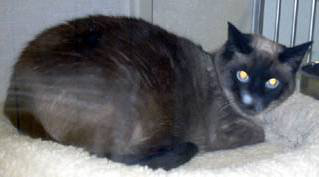

In [6]:
PIL.Image.open(str(cats[0]))

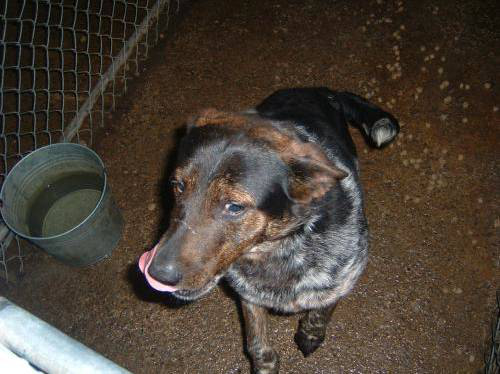

In [7]:
PIL.Image.open(str(dogs[0]))

In [8]:
batch_size = 64
new_img_size = (200, 200)
data_split = 0.2
seed_value = 42

train_ds = tf.keras.utils.image_dataset_from_directory(
    train_dir, 
    validation_split=data_split,
    subset='training', 
    seed=seed_value,
    image_size=new_img_size,
    batch_size=batch_size
)

val_ds = tf.keras.utils.image_dataset_from_directory(
    train_dir,
    validation_split=data_split,
    subset='validation',
    seed=seed_value,
    image_size=new_img_size,
    batch_size=batch_size,
)

Found 20000 files belonging to 2 classes.
Using 16000 files for training.
Found 20000 files belonging to 2 classes.
Using 4000 files for validation.


In [9]:
class_names = train_ds.class_names
class_names

['cats', 'dogs']

<Figure size 1000x1000 with 0 Axes>

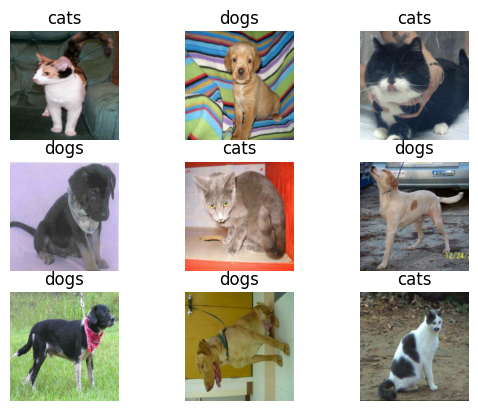

In [10]:
plt.figure(figsize=(10, 10))

for images, labels in train_ds.take(1):
    fig, ax = plt.subplots(3, 3)
    for i, ax in enumerate(ax.flat):
        ax.imshow(images[i].numpy().astype('uint8'))
        ax.set_title(class_names[labels[i]])
        ax.axis('off')
plt.show()

In [11]:
# AUTOTUNE used to to automatically determine the buffer sizes for caching and prefetching ops.
# cache func, caches the images upon first time load, for faster retrieval during training.
# shuffle is used to introduce randomness and prefent bias, the value indiciates the buffer size
# prefetch func, prefetches elements from the dataset when training, prefetchig overlaps the works of data loading and training.

# AUTOTUNE = tf.data.AUTOTUNE

# train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size = AUTOTUNE)
# val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

**Base Model**

In [12]:
num_classes = len(class_names)

with tf.device('/GPU:0'):
    model = tf.keras.Sequential([
        tf.keras.layers.Rescaling(1./255, input_shape=(new_img_size[0], new_img_size[1], 3)),
        tf.keras.layers.experimental.preprocessing.RandomFlip('horizontal'),
        tf.keras.layers.experimental.preprocessing.RandomRotation(0.3),

        tf.keras.layers.Conv2D(filters=16, kernel_size=3,  activation='relu', kernel_initializer='he_uniform', padding='same'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPooling2D(pool_size=2),
        tf.keras.layers.Dropout(0.2),

        tf.keras.layers.Conv2D(filters=32, kernel_size=3,  activation='relu', kernel_initializer='he_uniform', padding='same'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPooling2D(pool_size=2),
        tf.keras.layers.Dropout(0.2),

        tf.keras.layers.Conv2D(filters=64, kernel_size=3,  activation='relu', kernel_initializer='he_uniform', padding='same'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPooling2D(pool_size=2),
        tf.keras.layers.Dropout(0.2),

        tf.keras.layers.Conv2D(filters=128, kernel_size=3, activation='relu', kernel_initializer='he_uniform', padding='same'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPooling2D(pool_size=2),
        tf.keras.layers.Dropout(0.2),

        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(128, activation='relu', kernel_initializer='he_uniform'),
        tf.keras.layers.Dropout(0.35),
        tf.keras.layers.Dense(1, activation='sigmoid')  
    ])

    model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 200, 200, 3)       0         
                                                                 
 random_flip (RandomFlip)    (None, 200, 200, 3)       0         
                                                                 
 random_rotation (RandomRota  (None, 200, 200, 3)      0         
 tion)                                                           
                                                                 
 conv2d (Conv2D)             (None, 200, 200, 16)      448       
                                                                 
 batch_normalization (BatchN  (None, 200, 200, 16)     64        
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 100, 100, 16)     0

In [13]:
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
model.compile(loss='binary_crossentropy',
              optimizer=optimizer,
              metrics=['accuracy'])

In [14]:
current_working_dir = os.getcwd()

In [15]:
class MyThresholdCallback(tf.keras.callbacks.Callback):
    def __init__(self, threshold):
        super(MyThresholdCallback, self).__init__()
        self.threshold = threshold
        
    def on_epoch_end(self, epoch, logs=None):
        val_acc = logs['val_accuracy']
        if val_acc >= self.threshold:
            self.model.stop_training = True
            
early_stopping_callback = MyThresholdCallback(threshold = 0.92)

logdir = os.path.join(
    'logs', datetime.datetime.now().strftime('%Y%m%d-%H%M%S'))
modelfname = datetime.datetime.now().strftime('%Y%m%d-%H%M%S') + '.h5'

model_folder = pathlib.Path(os.path.join(current_working_dir, 'CatsAndDogs', 'model'))
mcp_save = tf.keras.callbacks.ModelCheckpoint(os.path.join(model_folder, modelfname),
                                             save_best_only=True, monitor='val_loss', mode='min')

tensorboard_callback = tf.keras.callbacks.TensorBoard(logdir, histogram_freq=1)

print(logdir)

# # tensorboard --port=6007 --logdir ~/CatsAndDogs/logs

epochs = 300
history = model.fit(train_ds,
                    validation_data=val_ds,
                    epochs=epochs,
                    verbose=1,
                    callbacks=[tensorboard_callback, mcp_save, early_stopping_callback]
                   )

logs/20230524-024700
Epoch 1/300
  6/250 [..............................] - ETA: 27s - loss: 5.1221 - accuracy: 0.5000

250/250 [==============================] - 58s 165ms/step - loss: 0.7712 - accuracy: 0.5935 - val_loss: 0.6924 - val_accuracy: 0.5825
Epoch 2/300
250/250 [==============================] - 36s 140ms/step - loss: 0.6089 - accuracy: 0.6598 - val_loss: 0.6344 - val_accuracy: 0.6390
Epoch 3/300
250/250 [==============================] - 35s 137ms/step - loss: 0.5883 - accuracy: 0.6821 - val_loss: 0.5723 - val_accuracy: 0.6835
Epoch 4/300
250/250 [==============================] - 36s 143ms/step - loss: 0.5628 - accuracy: 0.7059 - val_loss: 0.5426 - val_accuracy: 0.7215
Epoch 5/300
250/250 [==============================] - 36s 140ms/step - loss: 0.5514 - accuracy: 0.7206 - val_loss: 0.7502 - val_accuracy: 0.6357
Epoch 6/300
250/250 [==============================] - 37s 142ms/step - loss: 0.5209 - accuracy: 0.7479 - val_loss: 0.5867 - val_accuracy: 0.6858
Epoch 7/300
250/250 [==============================] - 36s 140ms/step - loss: 0.5054 - accuracy: 0.7625 - val_loss: 0.6593 - val_accurac

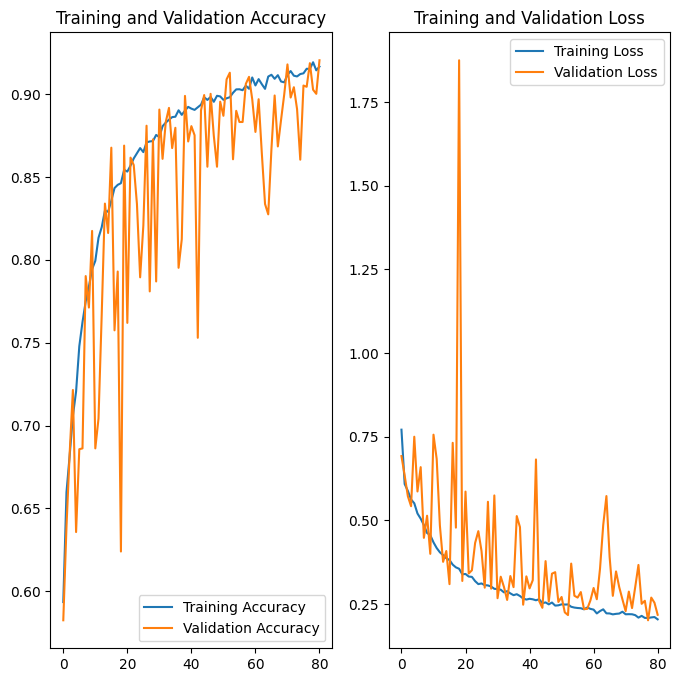

In [16]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss=history.history['loss']
val_loss=history.history['val_loss']

epochs_range = range(len(acc))

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1 )
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2 )
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()